### Урок 7. #Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях# 

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


Источник датасета https://www.kaggle.com/ronitf/heart-disease-uci


Описание:

1. age - age in years
2. sex - (1 = male; 0 = female)
3. chest pain type (4 values)
4. resting blood pressure - in mm Hg on admission to the hospital
5. serum cholestoral in mg/dl 
6. fasting blood sugar > 120 mg/dl - 1 = true; 0 = false
7. resting electrocardiographic results - values 0,1,2
8. maximum heart rate achieved 
9. exercise induced angina - (1 = yes; 0 = no) 
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment 
12. ca - number of major vessels (0-3) colored by flourosopy
13. thal - 3 = normal; 6 = fixed defect; 7 = reversable defect


In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

data = pd.read_csv("heart.csv")
data.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [29]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Пропусков нет.
Столбцы age, trestbps, chol, thalach приведем к меньшему разбросу

In [30]:
df_non_binary_features = data[['age', 
                            'cp', 
                            'trestbps', 
                            'chol',  
                            'restecg', 
                            'thalach', 
                            'oldpeak', 
                            'slope', 
                            'ca', 
                            'thal']]
df_binary = data[['sex', 'fbs', 'exang']]


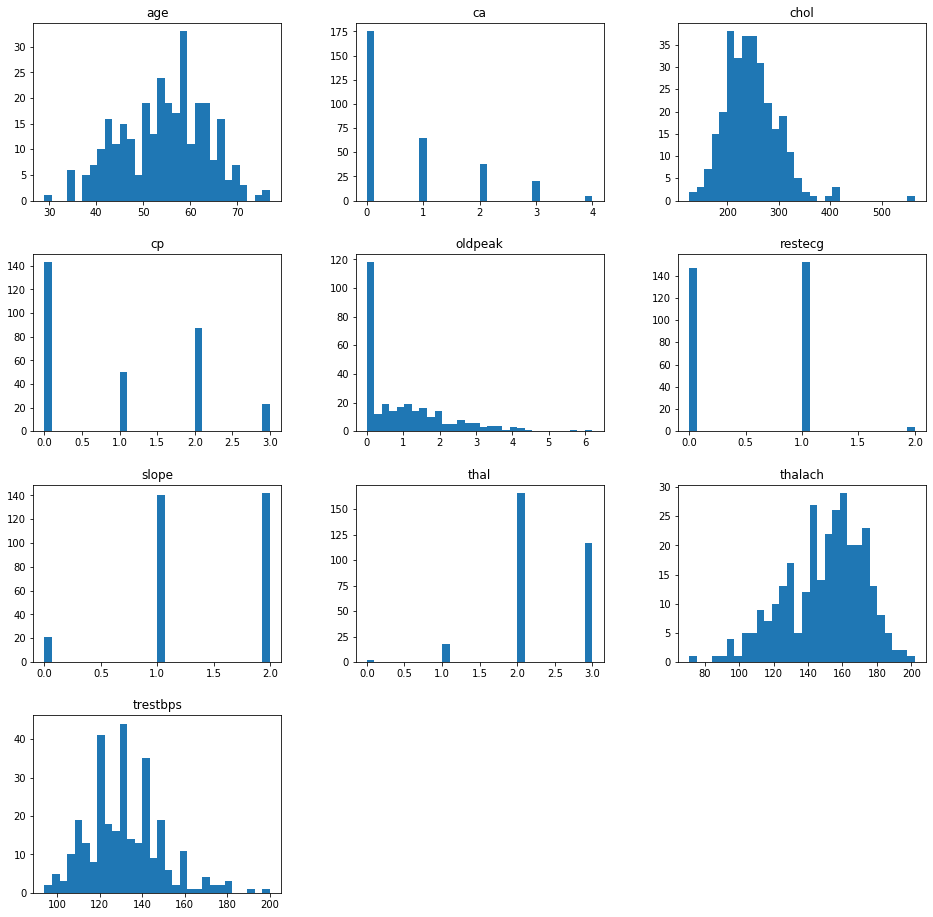

In [31]:
df_non_binary_features.hist(figsize=(16,16), bins=30, grid=False);

Судя по гистограмме есть выброс в Chol и проверим возраст

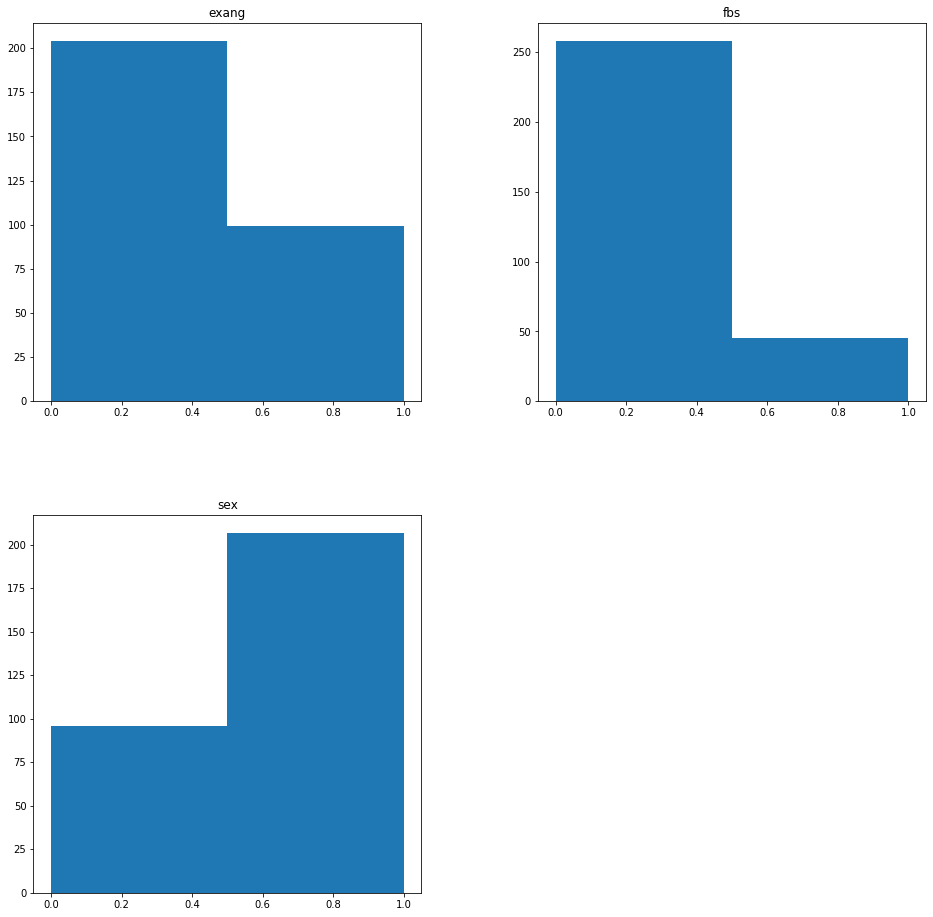

In [33]:
df_binary.hist(figsize=(16,16), bins=2, grid=False);

In [34]:
len(data.loc[data['age'] <=19]) #юношеского возраста нет

0

In [36]:
data.loc[data['age'] >=70] #юношеского возраста нет

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
25,71,0,1,160,302,0,1,162,0,0.4,2,2,2,1
60,71,0,2,110,265,1,0,130,0,0.0,2,1,2,1
129,74,0,1,120,269,0,0,121,1,0.2,2,1,2,1
144,76,0,2,140,197,0,2,116,0,1.1,1,0,2,1
145,70,1,1,156,245,0,0,143,0,0.0,2,0,2,1
151,71,0,0,112,149,0,1,125,0,1.6,1,0,2,1
225,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
234,70,1,0,130,322,0,0,109,0,2.4,1,3,2,0
238,77,1,0,125,304,0,0,162,1,0.0,2,3,2,0
240,70,1,2,160,269,0,1,112,1,2.9,1,1,3,0


In [37]:
cat_1 = len(data.loc[data['age'] <= 35]) #молодые
cat_2 = len(data.loc[(data['age'] > 35) & (data['age'] <= 50)])  #зрелые первая половина
cat_3 = len(data.loc[(data['age'] > 50) & (data['age'] < 60)]) #зрелые вторая половина
cat_4 = len(data.loc[(data['age'] >= 60) & (data['age'] < 76)]) # пожилые
cat_5 = len(data.loc[data['age'] >= 76]) # очень пожилые
cat_1 + cat_2 + cat_3 + cat_4 + cat_5 

303

Поделим возраст на группы

In [38]:
data.loc[data['age'] <= 35, 'age'] = 1
data.loc[(data['age'] > 35) & (data['age'] <= 48), 'age'] = 2
data.loc[(data['age'] > 48) & (data['age'] < 60), 'age'] = 3
data.loc[(data['age'] >= 60) & (data['age'] < 76), 'age'] = 4 
data.loc[data['age'] >= 76, 'age'] = 5
data['age'].value_counts()

3    130
4     88
2     76
1      7
5      2
Name: age, dtype: int64

In [39]:
cat_1 = len(data.loc[data['trestbps'] < 100])  #гипотония
cat_2 = len(data.loc[(data['trestbps'] >= 100) & (data['trestbps'] < 130)]) #норма
cat_3 = len(data.loc[(data['trestbps'] >= 130) & (data['trestbps'] < 140)]) #повышенное
cat_4 = len(data.loc[(data['trestbps'] >= 140) & (data['trestbps'] < 160)])  #гипертония 1 степени
cat_5 = len(data.loc[(data['trestbps'] >= 160) & (data['trestbps'] < 180)])  #гипертония 2 степени
cat_6 = len(data.loc[data['trestbps'] >= 180])  #гипертония 3 степени

cat_1 + cat_2 + cat_3 + cat_4 + cat_5 + cat_6

303

In [41]:
data.loc[data['trestbps'] < 100, 'trestbps'] = 1 
data.loc[(data['trestbps'] >= 100) & (data['trestbps'] < 130), 'trestbps'] = 2
data.loc[(data['trestbps'] >= 130) & (data['trestbps'] < 140), 'trestbps'] = 3
data.loc[(data['trestbps'] >= 140) & (data['trestbps'] < 160), 'trestbps'] = 4
data.loc[(data['trestbps'] >= 160) & (data['trestbps'] < 180), 'trestbps'] = 5
data.loc[data['trestbps'] >= 180, 'trestbps'] = 6
data['trestbps'].value_counts()

2    133
4     71
3     71
5     21
6      5
1      2
Name: trestbps, dtype: int64

In [42]:
data.loc[data['chol'] > 500]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
85,4,0,2,2,564,0,0,160,0,1.6,1,0,3,1


In [43]:
data.loc[data['chol'] < 200, 'chol'] = 1 # желательный 
data.loc[(data['chol'] >= 200) & (data['chol'] < 240), 'chol'] = 2 #  пограничный
data.loc[data['chol'] >= 240, 'chol'] = 3 #  высокий
data['chol'].value_counts()

3    155
2     98
1     50
Name: chol, dtype: int64

In [44]:
data.loc[data['thalach'] < 70, 'thalach'] = 1 # низкий
data.loc[(data['thalach'] >= 70) & (data['thalach'] < 100), 'thalach'] = 2 #  номальный
data.loc[data['thalach'] >= 100, 'thalach'] = 3 #  высокий
data['thalach'].value_counts()

3    295
2      8
Name: thalach, dtype: int64

In [45]:
data['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

примерно одинаковое распределение

In [46]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,3.006601,0.683168,0.966997,2.970297,2.346535,0.148515,0.528053,2.973597,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,0.813762,0.466011,1.032052,1.062193,0.747211,0.356198,0.525860,0.160595,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,3.000000,1.000000,1.000000,3.000000,3.000000,0.000000,1.000000,3.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,4.000000,1.000000,2.000000,4.000000,3.000000,0.000000,1.000000,3.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,5.000000,1.000000,3.000000,6.000000,3.000000,1.000000,2.000000,3.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [47]:
from sklearn.model_selection import train_test_split

x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [54]:
x_data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [48]:
model = GradientBoostingClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

In [49]:
results = {
    'approach': [],
    'f1': [],
    'roc': [],
    'recall':[],
    'precision':[]
}

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 



results['approach'].append('gbc')
results['f1'].append(f1_score(y_test, y_predict))
results['roc'].append(roc_auc_score(y_test, y_predict))
results['recall'].append(recall_score(y_test, y_predict, average='binary'))
results['precision'].append(precision_score(y_test, y_predict, average='binary'))

evaluate_results(y_test, y_predict)

Classification results:
f1: 78.79%
roc: 76.94%
recall: 83.87%
precision: 74.29%


In [53]:
model.feature_importances_

array([0.01647536, 0.04032863, 0.30798631, 0.02732873, 0.03244293,
       0.00866451, 0.01075075, 0.00448358, 0.03808453, 0.16475196,
       0.04503667, 0.13905175, 0.16461431])

In [61]:
features = pd.DataFrame(model.feature_importances_, 
                        x_data.columns, 
                        columns=['coefficient']).sort_values(by=['coefficient'], ascending=False)
features.head()

,coefficient
cp,0.307986
oldpeak,0.164752
thal,0.164614
ca,0.139052
slope,0.045037


In [65]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, x_test, y_test,
                            n_repeats=30,
                            random_state=0)

Пример как это может выглядеть на выходе

In [66]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{x_data.columns[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

ca       0.085 +/- 0.037
cp       0.034 +/- 0.039
thal     0.029 +/- 0.031
slope    0.028 +/- 0.020
exang    0.018 +/- 0.016
trestbps 0.017 +/- 0.012
sex      0.016 +/- 0.018
oldpeak  0.013 +/- 0.026
chol     0.010 +/- 0.008
fbs      0.002 +/- 0.008
thalach  0.000 +/- 0.000
restecg  -0.001 +/- 0.010
age      -0.003 +/- 0.010


In [68]:
import xgboost
import shap

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

In [77]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(x_data, label=y_data), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_data.iloc[0,:])

повышает аутпут chol = 2 (пограничный), thal = 1, cp = 3 (высокий уровень боли в груди), ca = 0;
понижает мужской пол и oldpeak = 2.3

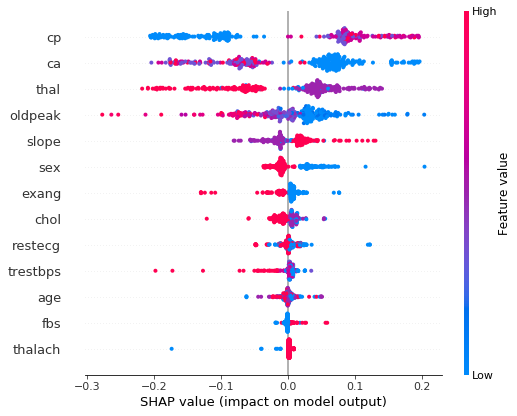

In [79]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_data)

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы и проверить их адекватность:
- чем ниже cp, тем ниже вероятность сердечного приступа
- чем выше trestbps, тем меньше вероятность сердечного приступа
- чем меньше ca, тем больше вероятность сердечного приступа
- чем меньше oldpeak, тем больше вероятность сердечного приступа
- 0 - female (у женщин видимо больше сердечных приступов)

Cредние значения SHAP для каждого признака

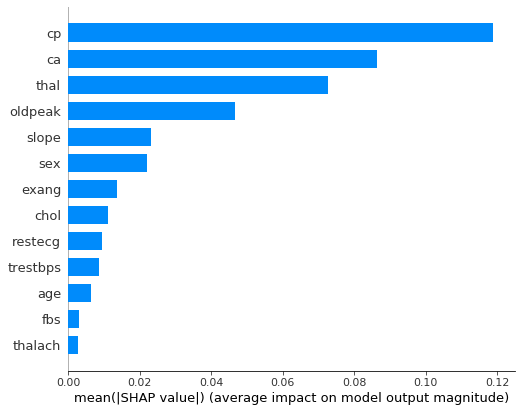

In [80]:
shap.summary_plot(shap_values, x_data, plot_type="bar")